In [1]:
import keras
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [14]:
def upSampling():
  model = Sequential()
  model.add(Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=dim))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(UpSampling2D((2, 2), interpolation='nearest'))
  model.add(Conv2D(16, (2, 2), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2), interpolation='nearest'))
  model.add(Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(UpSampling2D((2, 2), interpolation='nearest'))
  model.add(Conv2D(3, (2, 2), activation='linear', padding='same'))
  model.summary()
  return model
  

def convT():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=dim))
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
  model.add(Conv2DTranspose(8, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
  model.add(Conv2DTranspose(16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
  model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
  model.add(Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), activation='relu', kernel_initializer='he_normal'))
  model.add(Conv2D(3, kernel_size=(3, 3), activation='linear', padding='same'))
  model.summary()
  return model


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 14, 14, 32)        896       
                                                                 
 conv2d_83 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 conv2d_84 (Conv2D)          (None, 10, 10, 8)         1160      
                                                                 
 conv2d_transpose_68 (Conv2D  (None, 12, 12, 8)        584       
 Transpose)                                                      
                                                                 
 conv2d_transpose_69 (Conv2D  (None, 14, 14, 16)       1168      
 Transpose)                                                      
                                                                 
 conv2d_transpose_70 (Conv2D  (None, 16, 16, 32)     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


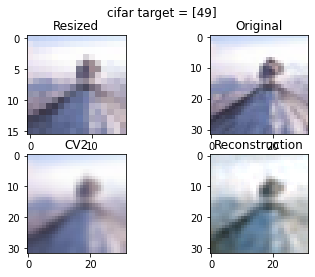

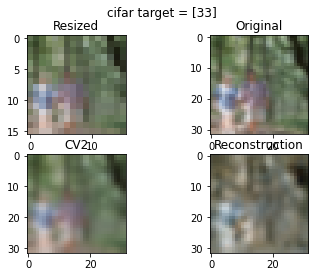

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


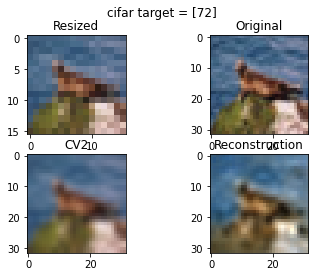

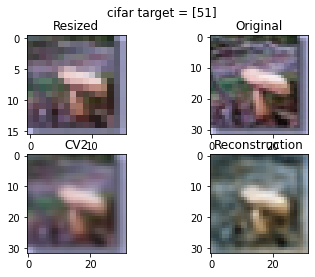

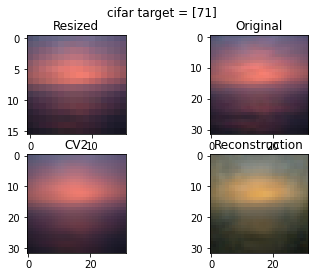

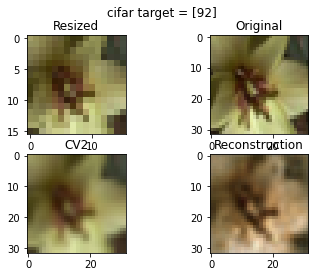

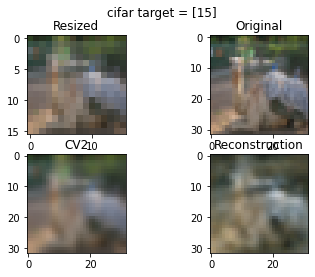

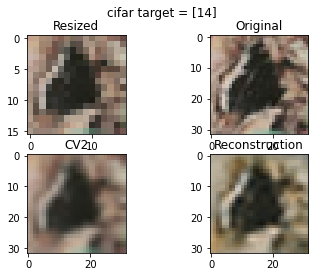

In [29]:
# Model configuration
resize_value = 2
batch_size = 32
no_epochs = 25
validation_split = 0.2

# Load Cifar dataset
(input_train_orginal, target_train), (input_test_orginal, target_test) = cifar100.load_data()
img_width, img_height, img_dim = input_train_orginal.shape[1], input_train_orginal.shape[2], input_train_orginal.shape[3]

# Resize data
dim = (img_width//resize_value, img_height//resize_value, img_dim)
input_train = np.zeros((input_train_orginal.shape[0], dim[0], dim[1], dim[2]))
for i in range(input_train.shape[0]):
  input_train[i] = cv2.resize(input_train_orginal[i], dim[:2])

input_test = np.zeros((input_test_orginal.shape[0], dim[0], dim[1], dim[2]))
for i in range(input_test.shape[0]):
  input_test[i] = cv2.resize(input_test_orginal[i], dim[:2])

# Reshape data
input_train = input_train.reshape(input_train.shape[0], dim[0], dim[1], dim[2])
input_test = input_test.reshape(input_test.shape[0], dim[0], dim[1], dim[2])

input_train_y = input_train_orginal.reshape(input_train_orginal.shape[0], img_width, img_height, dim[2])
input_test_y = input_test_orginal.reshape(input_test_orginal.shape[0], img_width, img_height, dim[2])

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

input_train_y = input_train_y.astype('float32')
input_test_y = input_test_y.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

input_train_y = input_train_y / 255
input_test_y = input_test_y / 255

# Create the model
model = convT()
# model = upSampling()


# Compile and fit data
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(input_train, input_train_y,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split)

# Generate reconstructions
num_reconstructions = 8
samples = input_test[:num_reconstructions]
samples_y = input_test_y[:num_reconstructions]
targets = target_test[:num_reconstructions]
reconstructions = model.predict(samples)

for i in np.arange(0, num_reconstructions):
  # Get the sample and the reconstruction
  sample = samples[i]
  sample_y = samples_y[i]
  reconstruction = reconstructions[i]
  reconstruction_cv2 = cv2.resize(sample, (img_width, img_height))
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 2)
  # Plot sample and reconstruciton
  plt.subplot(2, 2, 1)
  plt.imshow(sample)
  plt.title('Resized')
  plt.subplot(2, 2, 2)
  plt.imshow(sample_y)
  plt.title('Original')
  plt.subplot(2, 2, 3)
  plt.imshow(reconstruction_cv2)
  plt.title('CV2')
  plt.subplot(2, 2, 4)
  plt.imshow(reconstruction)
  plt.title('Reconstruction')
  plt.suptitle(f'cifar target = {input_class}')
  plt.show()